In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, GlobalAvgPool2D, Add, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score

from tensorflow.keras import Sequential, layers, losses
import cv2 as cv
import matplotlib.image

In [2]:
class_list = os.listdir('../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/')
class_directory = {"Ak": 0, "Ala_Idris": 1, "Buzgulu": 2, "Dimnit": 3, "Nazli": 4}

train_data = []

train_labels = []

for class_folder in class_list:
    if class_folder[0] != 'G':
        file_names = os.listdir(os.path.join("../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/", class_folder))
        for file_name in file_names:
            image = matplotlib.image.imread(os.path.join("../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/", class_folder, file_name))
            try:
                resized = cv.resize(image, (320,320), interpolation=cv.INTER_AREA)
                train_data.append(resized)
                train_labels.append(class_directory[class_folder])
        #             print(class_directory[class_folder])
            except:
                break
train_data = np.array(train_data)
train_labels = np.array(train_labels)

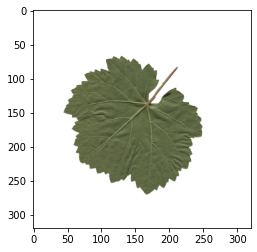

In [3]:
plt.imshow(train_data[0])

In [4]:
train_labels = train_labels.reshape((-1, 1))
train_data.shape, train_labels.shape

((500, 320, 320, 4), (500, 1))

In [5]:
from sklearn.utils import shuffle
train_data, train_labels = shuffle(train_data, train_labels)

In [6]:
train_data[0].shape

(320, 320, 4)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, shuffle=True, random_state=101)

## Autoencoder MODEL for Denoising the images

In [8]:
input = layers.Input(shape=(320, 320, 4))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)


x = layers.Flatten()(x)
latent_space = layers.Dense(1024)(x)
x = layers.Dense(20*20*16)(latent_space)
x = layers.Reshape(target_shape=(20,20,16))(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(4, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
encoded = Model(input, latent_space)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

2022-08-04 17:51:00.864936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 17:51:00.990339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 17:51:00.991222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 17:51:00.993357: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 4)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 320, 64)      2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 160, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0     

In [9]:
autoencoder.fit(
    x=X_train,
    y=X_train,
#     train_generator_resnet50,
    epochs=40,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
#     validation_data = val_generator_resnet50
)

2022-08-04 17:51:06.500197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-08-04 17:51:09.038498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13/13 [==============================] - 15s 407ms/step - loss: 0.5330 - val_loss: 0.3823
Epoch 2/40
13/13 [==============================] - 3s 263ms/step - loss: 0.3461 - val_loss: 0.3554
Epoch 3/40
13/13 [==============================] - 3s 264ms/step - loss: 0.3209 - val_loss: 0.3281
Epoch 4/40
13/13 [==============================] - 3s 268ms/step - loss: 0.3062 - val_loss: 0.3280
Epoch 5/40
13/13 [==============================] - 3s 264ms/step - loss: 0.3004 - val_loss: 0.3143
Epoch 6/40
13/13 [==============================] - 3s 258ms/step - loss: 0.2915 - val_loss: 0.3093
Epoch 7/40
13/13 [==============================] - 4s 288ms/step - loss: 0.2855 - val_loss: 0.3016
Epoch 8/40
13/13 [==============================] - 4s 274ms/step - loss: 0.2791 - val_loss: 0.2945
Epoch 9/40
13/13 [==============================] - 3s 261ms/step - loss: 0.2711 - val_loss: 0.2858
Epoch 10/40
13/13 [==============================] - 3s 265ms/step - loss: 0.2627 - val_loss: 0.2764
Epoch 11/

In [10]:
encoded_train = encoded.predict(X_train)
encoded_test = encoded.predict(X_test)

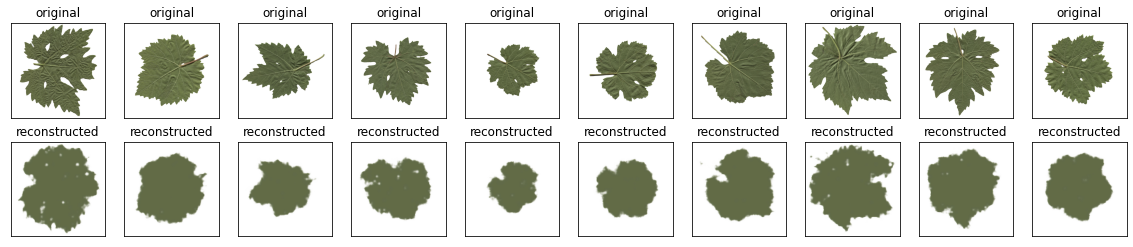

In [11]:
# plt.imshow(autoencoder.predict(X_test)[11])
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(autoencoder.predict(X_test)[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## MLP

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

In [13]:
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=32, verbose=False, early_stopping=True)

In [14]:
test = []
for a in y_train:
    test.append(a[0])
test = np.array(test)

test.shape

(400,)

In [15]:
clf.fit(encoded_train, test)

MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=(1024,))

In [16]:
y_pred = clf.predict(encoded_test)

In [17]:
tt = []
for a in y_test:
    tt.append(a[0])
tt = np.array(tt)
tt.shape

(100,)

In [18]:
print(classification_report(tt,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.26      0.31        19
           1       0.26      0.55      0.35        20
           2       0.56      0.43      0.49        23
           3       0.33      0.33      0.33        15
           4       0.73      0.35      0.47        23

    accuracy                           0.39       100
   macro avg       0.45      0.39      0.39       100
weighted avg       0.47      0.39      0.40       100



In [19]:
main_path = '../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

df = pd.DataFrame()


df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)



classes = []
paths = []
for image in df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

df['classes'] = classes
df['path'] = paths

In [20]:
df.head()

,images,classes,path
0,Ak (97).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
1,Ak (75).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
2,Ak (16).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
3,Ak (61).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
4,Ak (95).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) 

## ResNet MODEL

In [22]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
    ) 
train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_val,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
resnet50_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    ) 
test_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_test,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [23]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50(input_shape=(227, 227,3), include_top=False, weights='imagenet')

    resnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = resnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    resnet = tf.keras.Model(inputs, output)
#     resnet.summary()
    resnet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return resnet

In [24]:

resnet = create_model()
save_best = tf.keras.callbacks.ModelCheckpoint("best_resnet_model.h5", save_best_only=True)
history_resnet50 = resnet.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=45,
      batch_size=32,
      verbose=2, callbacks=[save_best])   

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/45
10/10 - 13s - loss: 2.1569 - accuracy: 0.2469 - val_loss: 1.5806 - val_accuracy: 0.3625


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/45
10/10 - 8s - loss: 1.5749 - accuracy: 0.3313 - val_loss: 1.3321 - val_accuracy: 0.5375
Epoch 3/45
10/10 - 8s - loss: 1.3641 - accuracy: 0.4187 - val_loss: 1.2214 - val_accuracy: 0.4875
Epoch 4/45
10/10 - 7s - loss: 1.1411 - accuracy: 0.5719 - val_loss: 1.1039 - val_accuracy: 0.5000
Epoch 5/45
10/10 - 9s - loss: 1.1015 - accuracy: 0.5594 - val_loss: 1.0776 - val_accuracy: 0.5625
Epoch 6/45
10/10 - 8s - loss: 0.9711 - accuracy: 0.6187 - val_loss: 0.9893 - val_accuracy: 0.5250
Epoch 7/45
10/10 - 8s - loss: 0.9116 - accuracy: 0.6562 - val_loss: 0.9260 - val_accuracy: 0.5750
Epoch 8/45
10/10 - 7s - loss: 0.7792 - accuracy: 0.7125 - val_loss: 0.8470 - val_accuracy: 0.6750
Epoch 9/45
10/10 - 8s - loss: 0.7292 - accuracy: 0.7563 - val_loss: 0.7248 - val_accuracy: 0.7250
Epoch 10/45
10/10 - 8s - loss: 0.6158 - accuracy: 0.7812 - val_loss: 0.5888 - val_accuracy: 0.7625
Epoch 11/45
10/10 - 8s - loss: 0.6418 - accuracy: 0.7656 - val_loss: 0.6324 - val_accuracy: 0.7250
Epoch 12/45
10/10 

In [25]:
resnet.evaluate(test_generator_resnet50)

4/4 [==============================] - 1s 189ms/step - loss: 0.7547 - accuracy: 0.7800


[0.7546724677085876, 0.7799999713897705]

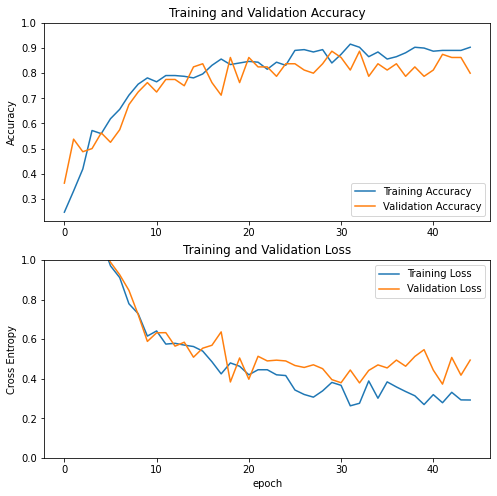

In [26]:
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']

loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning

In [27]:
# resnet_transfer_model = tf.keras.models.load_model('best_resnet_model.h5')

In [28]:
# resnet_transfer_model.trainable = True

In [29]:
# resnet_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# save_best = tf.keras.callbacks.ModelCheckpoint("best_resnet_model_2.h5", save_best_only=True)

# fine_tune = resnet_transfer_model.fit(
#       train_generator_resnet50,
#       validation_data=val_generator_resnet50,
#       epochs=20,
#       verbose=2)

In [30]:
# acc += fine_tune.history['accuracy']
# val_acc += fine_tune.history['val_accuracy']

# loss += fine_tune.history['loss']
# val_loss += fine_tune.history['val_loss']


# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([10-1,10-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([10-1,10-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

<AxesSubplot:>

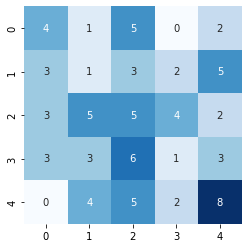

In [31]:
Y_pred = resnet.predict(val_generator_resnet50)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator_resnet50.classes, y_pred)
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

### Use different Seeds for Training

In [32]:
import random
seed = random.randint(0,100)
mean_accuracy = 0
for i in range(10):
    
    X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed) 
    
    resnet50_datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.10,
            brightness_range=[0.6,1.4],
            channel_shift_range=0.7,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=preprocess_input
    ) 
    train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
            X_train,  
            x_col='path',
            y_col='classes',
            target_size=(227, 227),  
            batch_size=32,
            class_mode="categorical",
            shuffle=True,
    )
    val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
            X_val,  
            x_col='path',
            y_col='classes',
            target_size=(227, 227),  
            batch_size=32,
            class_mode="categorical",
            shuffle=True,
    )
    resnet50_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
        ) 
    test_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
            X_test,  
            x_col='path',
            y_col='classes',
            target_size=(227, 227),  
            batch_size=32,
            class_mode="categorical",
            shuffle=True,
    )
    
    
    resnet_model = tf.keras.applications.ResNet50(input_shape=(227, 227,3), include_top=False, weights='imagenet')

    resnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = resnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    resnet = tf.keras.Model(inputs, output)
#     resnet.summary()
    resnet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    history_resnet = resnet.fit(train_generator_resnet50,  
                                  epochs=30)
    
    val_res = resnet.evaluate(val_generator_resnet50)
    test_res = resnet.evaluate(test_generator_resnet50)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)
    mean_accuracy += test_res[1]
print("mean accuracy with 10 random seeds: ", mean_accuracy)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
10/10 [==============================] - 8s 585ms/step - loss: 2.0843 - accuracy: 0.2062
Epoch 2/30
10/10 [==============================] - 6s 581ms/step - loss: 1.5670 - accuracy: 0.3219
Epoch 3/30
10/10 [==============================] - 7s 675ms/step - loss: 1.3750 - accuracy: 0.4062
Epoch 4/30
10/10 [==============================] - 6s 580ms/step - loss: 1.2104 - accuracy: 0.5125
Epoch 5/30
10/10 [==============================] - 6s 618ms/step - loss: 1.0860 - accuracy: 0.5531
Epoch 6/30
10/10 [==============================] - 6s 580ms/step - loss: 1.1184 - accuracy: 0.5156
Epoch 7/30
10/10 [==============================] - 6s 599ms/step - loss: 1.0061 - accuracy: 0.6250
Epoch 8/30
10/10 [==============================] - 6s 644ms/step - loss: 0.9291 - accuracy: 0.6406
Epoch 9/30
10/10 [===

In [33]:
print("Final Mean Accuracy: ", mean_accuracy/10.)

Final Mean Accuracy:  0.7999999940395355


## Cross Validation 

In [34]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
resnet50_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)


Y = y_train

for train_index, val_index in kf.split(np.zeros(400),Y):

    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]

    
    training_set = resnet50_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)

    validation_set = resnet50_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    test_set = resnet50_datagen.flow_from_dataframe(dataframe = X_test, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    
    resnet_model = tf.keras.applications.ResNet50(input_shape=(227, 227,3), include_top=False, weights='imagenet')

    resnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = resnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    resnet = tf.keras.Model(inputs, output)
#     resnet.summary()
    resnet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    history_resnet = resnet.fit(training_set,  
                                  epochs=30)


    #pred = model_resnet.predict_generator(test_set, len(X_test) // 32)

    val_res = resnet.evaluate(validation_set)
    test_res = resnet.evaluate(test_set)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)
# print(results)

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
12/12 [==============================] - 11s 613ms/step - loss: 2.3890 - accuracy: 0.1722
Epoch 2/30
12/12 [==============================] - 7s 565ms/step - loss: 1.6917 - accuracy: 0.2472
Epoch 3/30
12/12 [==============================] - 7s 538ms/step - loss: 1.4890 - accuracy: 0.3722
Epoch 4/30
12/12 [==============================] - 7s 615ms/step - loss: 1.2728 - accuracy: 0.4583
Epoch 5/30
12/12 [==============================] - 7s 574ms/step - loss: 1.1125 - accuracy: 0.5889
Epoch 6/30
12/12 [==============================] - 7s 593ms/step - loss: 0.9707 - accuracy: 0.6222
Epoch 7/30
12/12 [==============================] - 7s 565ms/step - loss: 0.9346 - accuracy: 0.6361
Epoch 8/30
12/12 [==============================] - 7s 569ms/step - loss: 0.8694 - accuracy: 0.6528
Epoch 9/30
12/12 [==

## VGG MODEL

In [35]:
from keras.applications.vgg19 import preprocess_input

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) 

In [37]:
vgg_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_train,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_val,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator_vgg = vgg_datagen.flow_from_dataframe(
        X_test,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [38]:
vgg19_model = tf.keras.applications.VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

vgg19_model.trainable = False

inputs = Input((227, 227,3))

base_model_output = vgg19_model(inputs)

x = GlobalAvgPool2D()(base_model_output)

x = Dense(units= 512, activation='relu')(x)
x = Dense(units= 256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units= 5, activation='softmax')(x)


vgg19 = tf.keras.Model(inputs, output)
vgg19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 227, 227, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_21  (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
___________________________________________________________

In [39]:
vgg19.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [40]:
save_best = tf.keras.callbacks.ModelCheckpoint("best_vgg_model.h5", save_best_only=True)
history_vgg = vgg19.fit(
      train_generator_vgg,
      validation_data=val_generator_vgg,
      epochs=45,
      verbose=2, callbacks=[save_best])

Epoch 1/45
10/10 - 14s - loss: 2.0706 - accuracy: 0.3313 - val_loss: 1.1656 - val_accuracy: 0.5500
Epoch 2/45
10/10 - 8s - loss: 1.2921 - accuracy: 0.4906 - val_loss: 1.2003 - val_accuracy: 0.5000
Epoch 3/45
10/10 - 8s - loss: 1.1590 - accuracy: 0.5781 - val_loss: 1.0937 - val_accuracy: 0.5250
Epoch 4/45
10/10 - 8s - loss: 0.9224 - accuracy: 0.6344 - val_loss: 1.0313 - val_accuracy: 0.5250
Epoch 5/45
10/10 - 8s - loss: 0.7285 - accuracy: 0.7625 - val_loss: 0.8989 - val_accuracy: 0.6750
Epoch 6/45
10/10 - 8s - loss: 0.7706 - accuracy: 0.7125 - val_loss: 0.8405 - val_accuracy: 0.6750
Epoch 7/45
10/10 - 8s - loss: 0.6672 - accuracy: 0.7563 - val_loss: 0.9620 - val_accuracy: 0.6750
Epoch 8/45
10/10 - 8s - loss: 0.6486 - accuracy: 0.7563 - val_loss: 1.1323 - val_accuracy: 0.6000
Epoch 9/45
10/10 - 8s - loss: 0.6645 - accuracy: 0.7594 - val_loss: 0.8924 - val_accuracy: 0.6875
Epoch 10/45
10/10 - 8s - loss: 0.4843 - accuracy: 0.8344 - val_loss: 0.8257 - val_accuracy: 0.7375
Epoch 11/45
10/10 

In [41]:
vgg19.evaluate(test_generator_vgg)

4/4 [==============================] - 2s 586ms/step - loss: 0.5849 - accuracy: 0.8100


[0.5849477648735046, 0.8100000023841858]

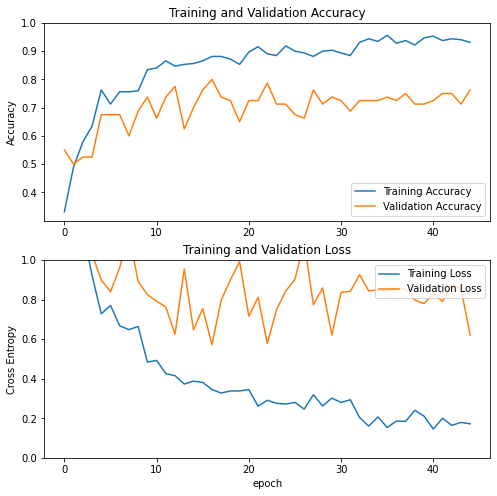

In [42]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<AxesSubplot:>

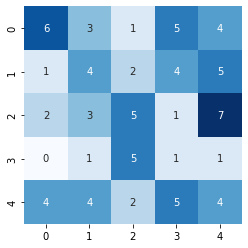

In [43]:
Y_pred = vgg19.predict(val_generator_vgg)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator_vgg.classes, y_pred)
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

## Cross Validation

In [44]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
resnet50_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)


Y = y_train

for train_index, val_index in kf.split(np.zeros(400),Y):

    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]

    
    training_set = resnet50_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)

    validation_set = resnet50_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    test_set = resnet50_datagen.flow_from_dataframe(dataframe = X_test, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    
    vgg19_model = tf.keras.applications.VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

    vgg19_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = vgg19_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    vgg19 = tf.keras.Model(inputs, output)
    
    vgg19.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    history_vgg = vgg19.fit(training_set,  
                                  epochs=30)


    #pred = model_resnet.predict_generator(test_set, len(X_test) // 32)

    val_res = vgg19.evaluate(validation_set)
    test_res = vgg19.evaluate(test_set)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)
# print(results)

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
12/12 [==============================] - 8s 591ms/step - loss: 2.1916 - accuracy: 0.3194
Epoch 2/30
12/12 [==============================] - 8s 615ms/step - loss: 1.3993 - accuracy: 0.4917
Epoch 3/30
12/12 [==============================] - 7s 589ms/step - loss: 1.0718 - accuracy: 0.6083
Epoch 4/30
12/12 [==============================] - 7s 549ms/step - loss: 0.9453 - accuracy: 0.6556
Epoch 5/30
12/12 [==============================] - 7s 553ms/step - loss: 0.7742 - accuracy: 0.7306
Epoch 6/30
12/12 [==============================] - 7s 623ms/step - loss: 0.7504 - accuracy: 0.7139
Epoch 7/30
12/12 [==============================] - 7s 573ms/step - loss: 0.7076 - accuracy: 0.7556
Epoch 8/30
12/12 [==============================] - 7s 626ms/step - loss: 0.7723 - accuracy: 0.7056
Epoch 9/30
12/12 [===

## MobileNet

In [45]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [46]:
mobilenet_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_mobilenet = mobilenet_datagen.flow_from_dataframe(
        X_train,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_mobilenet = mobilenet_datagen.flow_from_dataframe(
        X_val,  
        x_col='path',
        y_col='classes',
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.


In [47]:
mobilnet_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

mobilnet_model.trainable = False

inputs = Input((227, 227,3))

base_model_output = mobilnet_model(inputs)

x = GlobalAvgPool2D()(base_model_output)

x = Dense(units= 512, activation='relu')(x)
x = Dense(units= 256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units= 5, activation='softmax')(x)


mobilenet = tf.keras.Model(inputs, output)
mobilenet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 227, 227, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_32  (None, 1280)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_99 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_____________________________________________________________

In [48]:
mobilenet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [49]:
save_best = tf.keras.callbacks.ModelCheckpoint("best_mobilenet_model.h5", save_best_only=True)
history_mobilenet = mobilenet.fit(
      train_generator_mobilenet,
      validation_data=val_generator_mobilenet,
      epochs=50,
      callbacks=[save_best])

Epoch 1/50
13/13 [==============================] - 13s 809ms/step - loss: 1.6679 - accuracy: 0.2850 - val_loss: 1.2719 - val_accuracy: 0.4875


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
13/13 [==============================] - 9s 735ms/step - loss: 1.1089 - accuracy: 0.5575 - val_loss: 1.1325 - val_accuracy: 0.5375
Epoch 3/50
13/13 [==============================] - 10s 748ms/step - loss: 0.9433 - accuracy: 0.6050 - val_loss: 0.8112 - val_accuracy: 0.7000
Epoch 4/50
13/13 [==============================] - 9s 720ms/step - loss: 0.8146 - accuracy: 0.6975 - val_loss: 0.7369 - val_accuracy: 0.7000
Epoch 5/50
13/13 [==============================] - 10s 774ms/step - loss: 0.7999 - accuracy: 0.7150 - val_loss: 0.7217 - val_accuracy: 0.7250
Epoch 6/50
13/13 [==============================] - 9s 720ms/step - loss: 0.7032 - accuracy: 0.7075 - val_loss: 0.6010 - val_accuracy: 0.7875
Epoch 7/50
13/13 [==============================] - 10s 731ms/step - loss: 0.6393 - accuracy: 0.7500 - val_loss: 0.4900 - val_accuracy: 0.8375
Epoch 8/50
13/13 [==============================] - 10s 786ms/step - loss: 0.6492 - accuracy: 0.7575 - val_loss: 0.5499 - val_accuracy: 0.8000
Ep

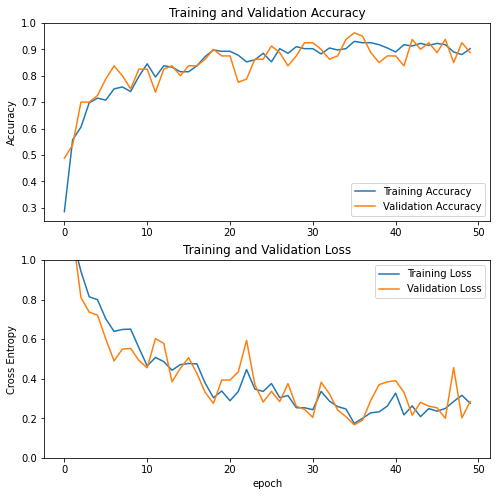

In [50]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']

loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<AxesSubplot:>

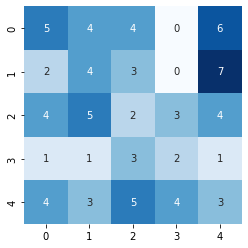

In [51]:
Y_pred = mobilenet.predict(val_generator_mobilenet)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator_mobilenet.classes, y_pred)
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [52]:
mobilenet.evaluate(val_generator_mobilenet)

3/3 [==============================] - 1s 426ms/step - loss: 0.2621 - accuracy: 0.8625


[0.26209232211112976, 0.862500011920929]

In [53]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
resnet50_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[['path', 'classes']], df[['classes']], test_size=0.2, random_state=42)


Y = y_train

for train_index, val_index in kf.split(np.zeros(400),Y):

    training_data = X_train.iloc[train_index]
    validation_data = X_train.iloc[val_index]

    
    training_set = resnet50_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)

    validation_set = resnet50_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    test_set = resnet50_datagen.flow_from_dataframe(dataframe = X_test, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    
    mobilnet_model = tf.keras.applications.MobileNetV2(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

    mobilnet_model.trainable = False

    inputs = Input((227, 227,3))

    base_model_output = mobilnet_model(inputs)

    x = GlobalAvgPool2D()(base_model_output)

    x = Dense(units= 512, activation='relu')(x)
    x = Dense(units= 256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units= 5, activation='softmax')(x)


    mobilenet = tf.keras.Model(inputs, output)
    
    mobilenet.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    history_mobilenet = mobilenet.fit(training_set,  
                                  epochs=30)


    #pred = model_resnet.predict_generator(test_set, len(X_test) // 32)

    val_res = mobilenet.evaluate(validation_set)
    test_res = mobilenet.evaluate(test_set)
    print("Validation Result: ", val_res)
    print("Test Result: ", test_res)
# print(results)

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/30
12/12 [==============================] - 9s 547ms/step - loss: 1.6751 - accuracy: 0.3056
Epoch 2/30
12/12 [==============================] - 7s 554ms/step - loss: 1.2308 - accuracy: 0.4889
Epoch 3/30
12/12 [==============================] - 7s 563ms/step - loss: 0.9213 - accuracy: 0.6278
Epoch 4/30
12/12 [==============================] - 7s 588ms/step - loss: 0.8613 - accuracy: 0.7000
Epoch 5/30
12/12 [==============================] - 8s 637ms/step - loss: 0.6979 - accuracy: 0.7361
Epoch 6/30
12/12 [==============================] - 7s 625ms/step - loss: 0.6439 - accuracy: 0.7583
Epoch 7/30
12/12 [==============================] - 7s 578ms/step - loss: 0.5759 - accuracy: 0.7778
Epoch 8/30
12/12 [==============================] - 7s 557ms/step - loss: 0.5731 - accuracy: 0.8000
Epoch 9/30
12/12 [===